In [1]:
# ONLY ON MY COMPUTER
import sys
import sys,os,os.path
python_path = ['', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/xgboost-0.6-py2.7.egg', '/Users/Melancardie/Dropbox/Documents/My School/NYU/Spring 2017/DS-GA 1008/HW/hw3/ALI']

for p in python_path:
    if p not in sys.path:
        sys.path.append(p)


In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.linear_model import LogisticRegression
import os
import spacy
nlp = spacy.load('en')
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
from collections import Counter

%matplotlib inline




In [3]:
# DATA LOADING FUNCTIONS

# split dataset
def split_dataset(full_data, train_ratio, validation_ratio, test_ratio):
    """
    Function that splits the dataset into train, validation, and test
    """
    random_idx = np.random.permutation(len(full_data))
    train_threshold = int(round(train_ratio*len(full_data)))
    validation_threshold = int(round((train_ratio+validation_ratio)*len(full_data)))
    
    train_set = full_data.iloc[random_idx[:train_threshold]]
    validation_set = full_data.iloc[random_idx[train_threshold:validation_threshold]]
    test_set = full_data.iloc[random_idx[validation_threshold:]]
    
    return train_set, validation_set, test_set


# load dataset
def load_datasets(load_dir = "../data/kaggle_competition/", prefix="clean_kaggle_", post_fix=""):
    """
    Function that loads the dataset
    """
    train_set = pd.read_csv(os.path.join(load_dir, "{0}train{1}.csv".format(prefix,post_fix)), keep_default_na=False)
    validation_set = pd.read_csv(os.path.join(load_dir, "{0}validation{1}.csv".format(prefix,post_fix)), keep_default_na=False)
    test_set = pd.read_csv(os.path.join(load_dir, "{0}test{1}.csv".format(prefix,post_fix)), keep_default_na=False)
    return train_set, validation_set, test_set

def xy_split(df, label_col="is_duplicate"):
    """
    Function that splits a data frame into X and y
    """
    return df.drop(label_col, axis=1), df[label_col]


In [4]:
# DATA CLEANING FUNCTIONS
def clean_str(input_str):
    """
    Helper function that converts string to ASCII
    """
    # trivial case
    if pd.isnull(input_str) or type(input_str)==np.float or type(input_str)==float:
        return ""
    # encoding
    input_str = input_str.decode('ascii', 'ignore').lower()
    return input_str

def clean_dataset(full_dataset):
    """
    Function that cleans the full dataset
    """
    full_dataset["clean_q1"] = full_dataset["question1"].apply(clean_str,1)
    full_dataset["clean_q2"] = full_dataset["question2"].apply(clean_str,1)
    col_need = ["clean_q1", "clean_q2"]
    if "is_duplicate" in full_dataset.columns:
        col_need += ["is_duplicate"]
    return full_dataset[col_need]

In [5]:
# FEATURE ENGINEERING FUNCTIONS
def word_overlap(row):
    """
    Function that calculates the percentage of word overlap
    """
    avg_length = float(len(row['token_1'])+len(row['token_2']))/2
    same_token_num = len(set(row['token_1']).intersection(set(row['token_2'])))
    return float(same_token_num)/avg_length

def overlap_no_stops(row,stops=stops):
    q1words = {}
    q2words = {}
    for word in row['token_1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['token_2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words = [w for w in q1words.keys() if w in q2words]
    return 2*(len(shared_words))/(len(q1words) + len(q2words))

def sentence_similarity(row):
    """
    Function that returns the Spacy sentence similarity
    """
    return row["doc1"].similarity(row["doc2"])


def jaccard_sim(set1, set2):
    """
    Jaccard Similarity
    """
    if len(set1.union(set2)) == 0:
        return 0.0
    else:
        return float(len(set1.intersection(set2)))/len(set1.union(set2))

def jaccard_sim_unhashbale(set1, set2):
    """
    Jaccard Similarity
    """
    count = 0.0
    str_set2 = str(set2)
    for i in set1:
        if str(i) in str_set2:
            count += 1.0
    if (len(set1)+len(set2)-count) == 0:
        return 0.0
    else:
        return count/ (len(set1)+len(set2)-count)
    
    
def load_embedding(glove_file="/Users/Melancardie/Dropbox/Documents/My Research/NYU/Sundararajan/trust/lib/glove.6B/glove.6B.50d.txt",
                   line_to_load = 50000):
    """
    Function that populates a dictionary with word embedding vectors
    """
    ctr = 0
    word_emb = {}
    with open(glove_file, "r") as f:
        for i, line in enumerate(f):
            contents = line.split()
            word_emb[contents[0]]=np.asarray(contents[1:]).astype(float)
            ctr += 1
            if ctr >= line_to_load:
                break
    return word_emb
glove_emb = load_embedding()
 

    
def vectorize_tokens(token_list, word_emb, dim=50):
    """
    Function that vectorize phrases from a counter
    """
    ctr = 0.0
    vec = np.zeros(dim)
    for token in token_list:
        if token in word_emb:
            vec += word_emb[token].astype(float)
            ctr += 1
    if ctr == 0 :
        return vec
    else:
        return vec / float(ctr)
    
def emb_dist(row, embedding):
    """
    Function that calculates the euclidean distance among two embeddings
    """
    # embedding
    emb1 = vectorize_tokens(row["token_1"], embedding)
    emb2 = vectorize_tokens(row["token_2"], embedding)
    return np.linalg.norm(emb1-emb2)

def emb_diff(row, embedding, emb_mat):
    """
    Function that calculates the euclidean distance among two embeddings
    """
    # embedding
    emb1 = vectorize_tokens(row["token_1"], embedding)
    emb2 = vectorize_tokens(row["token_2"], embedding)
    emb_mat.append(np.abs(emb1-emb2))
     

def feature_engineering(df, embedding=glove_emb, normalize=False, stops=stops):
    """
    Feature engineering function
    """
    total_begin = time.time()
    
    # preprocessing #
    # tokenization
    df['token_1'] = df.apply(lambda x: nltk.word_tokenize(x["clean_q1"]), 1)
    df['token_2'] = df.apply(lambda x: nltk.word_tokenize(x["clean_q2"]), 1)
    # spacy rep
    df['doc1'] = df.apply(lambda x: nlp(unicode(x["clean_q1"], "utf-8")), 1)
    df['doc2'] = df.apply(lambda x: nlp(unicode(x["clean_q2"], "utf-8")), 1)
    # capitalized spacy rep
    df['cap_doc1'] = df.apply(lambda x: nlp(unicode(x["clean_q1"].upper(), "utf-8")), 1)
    df['cap_doc2'] = df.apply(lambda x: nlp(unicode(x["clean_q2"].upper(), "utf-8")), 1)
    # entity
    df['entity_set_1'] = df.apply(lambda x: x["cap_doc1"].ents, 1)
    df['entity_set_2'] = df.apply(lambda x: x["cap_doc2"].ents, 1)
    # name chunk
    df['noun_chunks_1'] = df.apply(lambda x: [chunk for chunk in x["cap_doc1"].noun_chunks], 1)
    df['noun_chunks_2'] = df.apply(lambda x: [chunk for chunk in x["cap_doc2"].noun_chunks], 1)

    preprocess_time = time.time()
    print("preprocessed  for {0} seconds".format(preprocess_time-total_begin))
    
    # length #
    df.loc[:,"len_1"] = df.apply(lambda x: len(x["token_1"]), 1)
    df.loc[:,"len_2"] = df.apply(lambda x: len(x["token_2"]), 1)
    df.loc[:,"len_diff"] = np.abs(df["len_1"]-df["len_2"])
    df.loc[:,"len_diff_percent"] = np.abs(df["len_1"]-df["len_2"]) /((df["len_1"]+df["len_2"])/2)
    after_length = time.time()
    print("length fueature loaded for {0} seconds".format(after_length-preprocess_time))
    
    # first words match #
    df.loc[:,"first_word_q1"] = df.apply(lambda x: x["clean_q1"].split(" ")[0], 1)
    df.loc[:,"first_word_q2"] = df.apply(lambda x: x["clean_q2"].split(" ")[0], 1)
    df.loc[:,"first_word_match"] = (df["first_word_q1"] == df["first_word_q2"])
    after_first = time.time()
    print("first word feature loaded for {0} seconds".format(after_first-after_length))
    
    # bag of words #
#     if tokenizer is None:
#         bag_of_word_tokenizer = CountVectorizer(stop_words="english", max_features=top_k_word)
#     else:
#         bag_of_word_tokenizer = tokenizer
#     q1_matrix = bag_of_word_tokenizer.fit_transform(df["clean_q1"]).astype(np.float)
#     q2_matrix = bag_of_word_tokenizer.fit_transform(df["clean_q2"]).astype(np.float)
#     df["vec_q1"] = [q1_matrix[i] for i in range(len(df))]
#     df["vec_q2"] = [q2_matrix[i] for i in range(len(df))]
#     print("question vectorized")

    
    # similarity measure #
    #cosine_sim = [cosine_similarity(q1_matrix[i], q2_matrix[i])[0][0] for i in range(len(df))]
    #df["cosine_sim"] = cosine_sim
    #Overlap percent
    df.loc[:,"overlap_percent"] = df.apply(word_overlap, 1)
    df.loc[:,"overlap_no_stops"] = df.apply(overlap_no_stops, 1)    
    # Spacy stentence similarity
    df.loc[:,"spacy_sentence_similarity"] = df.apply(sentence_similarity, 1)
    # edit distance
    df.loc[:,"edit_distance"] = df.apply(lambda x: nltk.edit_distance(x["token_1"], x["token_2"]), 1)
    # token Jaccard
    df.loc[:,"token_jaccard"] = df.apply(lambda x: jaccard_sim(set(x["token_1"]), set(x["token_2"])), 1)
    after_sim = time.time()
    print("similarity feature loaded for {0} seconds".format(after_sim-after_first))
    
    # embedding #
    # embedding diff -- UGLY
    dim_emb = embedding.values()[0].shape[0]
    emb_mat = []
    df.apply(lambda x: emb_diff(x, embedding, emb_mat), 1)
    emb_mat = np.array(emb_mat)
    for dim in range(dim_emb):
        df["emb_diff_dim_{0}".format(dim)] = emb_mat[:,dim]
    # euclidean distance - embedding
    df.loc[:,"emb_dist"] = df.apply(lambda x: emb_dist(x, embedding), 1)
    after_emb = time.time()
    print("embedding feature loaded for {0} seconds".format(after_emb-after_sim))
    
    # entity features #
    # entity same
    df.loc[:,"entity_same"] = df.apply(lambda x: x["entity_set_1"]==x["entity_set_2"], 1)
    # entity # same
    df.loc[:,"entity_len_same"] = df.apply(lambda x: len(x["entity_set_1"])==len(x["entity_set_2"]), 1)
    # entity # diff
    df.loc[:,"entity_len_diff"] = df.apply(lambda x: np.abs(len(x["entity_set_1"])-len(x["entity_set_2"])), 1)
    # entity Jaccard
    df.loc[:,"entity_jaccard"] = df.apply(lambda x: jaccard_sim_unhashbale(x["entity_set_1"], x["entity_set_2"]), 1)
    
    # noun chunk same
    df.loc[:, "chunk_same"] = df.apply(lambda x: x["noun_chunks_1"]==x["noun_chunks_2"], 1)
    # noun chunk # same
    df.loc[:,"chunk_len_same"] = df.apply(lambda x: len(x["noun_chunks_1"])==len(x["noun_chunks_2"]), 1)
    # noun chunk # diff
    df.loc[:,"chunk_len_diff"] = df.apply(lambda x: np.abs(len(x["noun_chunks_1"])-len(x["noun_chunks_2"])), 1)
    # noun chunk Jaccard
    df.loc[:,"chunk_jaccard"] = df.apply(lambda x: jaccard_sim_unhashbale(x["noun_chunks_1"], x["noun_chunks_2"]), 1)
    after_entity = time.time()
    print("entity feature loaded for {0} seconds".format(after_entity-after_emb))
    
    
    # filter columns
    ignore_columns = ["first_word_q1", "first_word_q2", "clean_q1", "clean_q2", "token_1", "token_2", 
                      "doc1", "doc2", "cap_doc1", "cap_doc2", "noun_chunks_1", "noun_chunks_2",
                     "entity_set_1", "entity_set_2"]
    col_normalize = ['len_1', 'len_2', 'len_diff', 'edit_distance', 'emb_dist', 'entity_len_diff', 'chunk_len_diff']
    #full_feature_df = df
    clean_feature_df = df.drop(ignore_columns, axis=1)
    if normalize:
        for col in clean_feature_df.columns:
            if str(col) in col_normalize:
                col_max = np.max(clean_feature_df[col])
                col_min = np.min(clean_feature_df[col])
                clean_feature_df[col] = (clean_feature_df[col]-col_min)/float(col_max-col_min)
    after_normalize = time.time()
    print("normalization time = {0}".format(time.time()-after_normalize))
    print("total time = {0}".format(time.time()-total_begin))
    return clean_feature_df
    


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Melancardie/Dropbox/Documents/My Research/NYU/Sundararajan/trust/lib/glove.6B/glove.6B.50d.txt'

In [4]:
# DATA CREATION SCRIPTS
# Quora Dataset
#full_data = pd.read_csv("../data/questions.csv")
# Kaggle Dataset
# begin_time = time.time()
# kaggle_train = pd.read_csv("../data/kaggle_competition/origin/train.csv")
# kaggle_test = pd.read_csv("../data/kaggle_competition/origin/test.csv")
# print("data loaded, used {0} seconds".format(time.time()-begin_time))

# clean dataset
# begin_time = time.time()
# clean_train = clean_dataset(kaggle_train)
# clean_test = clean_dataset(kaggle_test)
#clean_train.to_csv("../data/kaggle_competition/clean_datasets/clean_train.csv", index=False)
#clean_test.to_csv("../data/kaggle_competition/clean_datasets/clean_test.csv", index=False)
#print("data cleaned, used {0} seconds".format(time.time()-begin_time))


# split and save dataset
#begin_time = time.time()
# since Kaggle has its own test set, test_ratio=0
# train_set, validation_set, _ = split_dataset(clean_train, 0.8, 0.2, 0)
# test_set = clean_test
# train_set.to_csv("../data/kaggle_competition/clean_kaggle_train.csv", index=False)
# validation_set.to_csv("../data/kaggle_competition/clean_kaggle_validation.csv", index=False)
# test_set.to_csv("../data/kaggle_competition/clean_kaggle_test.csv", index=False)
# load splitted dataset
train_set, validation_set, test_set = load_datasets()
# print("data splitted, used {0} seconds".format(time.time()-begin_time))


# feature engineering
# begin_time = time.time()
# feature_train = feature_engineering(train_set)
# feature_train.to_csv("../data/kaggle_competition/feature_datasets/feature_train_v2.csv", index=False)
# feature_validation = feature_engineering(validation_set)
# feature_validation.to_csv("../data/kaggle_competition/feature_datasets/feature_validation_v2.csv", index=False)
# feature_test = feature_engineering(test_set)
# feature_test.to_csv("../data/kaggle_competition/feature_datasets/feature_test_v2.csv", index=False)
# print("data featurized, used {0} seconds".format(time.time()-begin_time))
feature_train, feature_validation, feature_test= load_datasets(load_dir = "../data/kaggle_competition/", prefix="feature_", post_fix="_v2")
# load splitted dataset
# train_set, validation_set, test_set = load_datasets()
# print("data splitted, used {0} seconds".format(time.time()-begin_time))

# split X, y
#X_train, y_train = xy_split(feature_train)
#X_validate, y_validate = xy_split(feature_validation)
#X_test=feature_test.as_matrix()

In [ ]:
print(len(train_set))
print(len(validation_set))
print(len(test_set))
feature_train = feature_engineering(train_set.head(1000))

In [ ]:
X_train


In [ ]:
print (X_train.shape)
print (y_train.shape)
print (X_validate.shape)
print (y_validate.shape)
print (X_test.shape)

In [ ]:
#mat1 = full_feature_df["vec_q1"].iloc[0]
#mat2 = full_feature_df["vec_q2"].iloc[0]

#cosine_similarity(mat1[5], mat2[5])
#a = time.time()
#cosine_similarity(full_feature_df["vec_q1"].iloc[10],full_feature_df["vec_q2"].iloc[10] )
#print time.time()-a
#len(full_feature_df)
#full_feature_df.to_csv("../data/full_feature_df.csv", index=False)
#np.sum(clean_feature_df["cosine_sim"]==0)/float(len(clean_feature_df))

In [ ]:
#mat1 = mat1.astype(np.float)
#mat2 = mat2.astype(np.float)
#cosine_similarity(mat1, mat2)

In [ ]:
# PREDICTIVE MODEL FUNCTIONS

In [ ]:
# MODEL ANALYTICS FUNCTIONS
def all_test_metrics(y_pred, y_test, metrics_list=["acc", "auc", "f1", "nll"]):
    score_dict = {}
    # acc
    if "acc" in metrics_list:
        y_pred_acc = np.round(y_pred).astype(np.int8)
        acc = metrics.accuracy_score(y_test, y_pred_acc, normalize=True)
        score_dict["acc"] = acc 
    # auc
    if "auc" in metrics_list:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        score_dict["auc"] = auc
        #score_dict["fpr"] = fpr
        #score_dict["tpr"] = tpr
    # f1-measure
    if "f1" in metrics_list:
        y_pred_acc = np.round(y_pred).astype(np.int8)
        f1 = metrics.f1_score(y_test, y_pred_acc, labels=[0,1], pos_label=1)
        score_dict["f1"] = f1
    # nll
    if "nll" in metrics_list:
        nll = metrics.log_loss(y_test, y_pred)
        score_dict["nll"] = nll
    return score_dict


def test_model(model, X_test, y_test, verbose=True, model_name="", y_pred_test=None, pred_lambda=None):
    """
    Function that generate performance stats for a model
    """
    if y_pred_test is None:
        if pred_lambda is None:
            y_pred_test = model.predict(X_test)
        else:
            y_pred_test = pred_lambda(model, X_test)  
    scores = all_test_metrics(y_pred_test, y_test)    
    if verbose:
        print(model_name+":")
        print(scores)
    return y_pred_test, scores
    
    

In [ ]:
# MODEL ANALYTICS SCRIPT
n_valid = len(validation_set)
n_test = len(test_set)

# baseline 1: majority class
y_pred_valid = [0 for i in range(n_valid)]
#y_pred_test = [0 for i in range(n_test)]
_, score_majority_class_valid = test_model(None, None, y_validate, 
                                        verbose=True, model_name="Baseline 1 - Majority Class (Validation):",
                                        y_pred_test=y_pred_valid)

# baseline 2: simple word overlap
y_pred_valid = X_validate[:,5].astype(np.double)
#y_pred_test = X_test[:,5].astype(np.double)
_, score_majority_class_valid = test_model(None, None, y_validate, 
                                        verbose=True, model_name="Baseline 2 - Simple Word Overlap (Validation):",
                                        y_pred_test=y_pred_valid)

# baseline 3: logistic regression
lr = LogisticRegression()
lr_lambda = lambda model, x: model.predict_proba(x)[:,1]
lr.fit(X_train, y_train)
lr_pred_valid, score_majority_class_valid = test_model(lr, X_validate, y_validate, verbose=True,
                                                       model_name="Baseline 3 - Simple Logistic Regression (Validation):",
                                                      pred_lambda=lr_lambda)


In [5]:
X_train, y_train = xy_split(feature_train)
X_validate, y_validate = xy_split(feature_validation)

[0]	train-logloss:0.643507	valid-logloss:0.643459
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.516641	valid-logloss:0.518384
[20]	train-logloss:0.500871	valid-logloss:0.504695
[30]	train-logloss:0.494178	valid-logloss:0.499938
[40]	train-logloss:0.487985	valid-logloss:0.496377
[50]	train-logloss:0.482687	valid-logloss:0.493426
[60]	train-logloss:0.478363	valid-logloss:0.491634
[70]	train-logloss:0.474179	valid-logloss:0.490038
[80]	train-logloss:0.471028	valid-logloss:0.488876
[90]	train-logloss:0.467795	valid-logloss:0.48784
[100]	train-logloss:0.464972	valid-logloss:0.487171
[110]	train-logloss:0.461326	valid-logloss:0.486216
[120]	train-logloss:0.458852	valid-logloss:0.48565
[130]	train-logloss:0.456077	valid-logloss:0.484956
[140]	train-logloss:0.453539	valid-logloss:0.484286
[150]	train-logloss:0.451763	valid-logloss:0.483978
[160]	train-logloss:0.450253	v

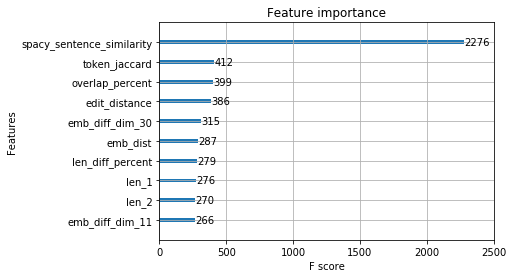

In [9]:
#XG BOOST
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
#params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_validate, label=y_validate)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=10)
xgb.plot_importance(bst,height=0.2,max_num_features=10)

In [7]:
from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR

rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)
print("RFR fitted")

y_rfr_predicted = rfr.predict_proba(X_validate)
logloss_rfr = calculate_logloss(y_validate, y_rfr_predicted)


print ("The calculated log loss value on the test set using RFR is = %f" %logloss_rfr)
 

RFR fitted
The calculated log loss value on the test set using RFR is = 0.718086


In [8]:
rfr.feature_importances_

array([ 0.01280438,  0.01379341,  0.01530613,  0.01142493,  0.00593536,
        0.07411743,  0.04070718,  0.04174546,  0.04766713,  0.01285252,
        0.0126964 ,  0.0128552 ,  0.01281804,  0.01827881,  0.01298953,
        0.01366917,  0.01597836,  0.01286055,  0.01545714,  0.01308489,
        0.01402117,  0.01286599,  0.01330257,  0.01322815,  0.01288102,
        0.01290483,  0.01332186,  0.01296168,  0.01349285,  0.01403537,
        0.01289862,  0.01295864,  0.01279008,  0.01322735,  0.0130327 ,
        0.01352071,  0.013005  ,  0.01328356,  0.01319834,  0.01375683,
        0.01351864,  0.0128252 ,  0.01280906,  0.01387897,  0.0130979 ,
        0.01358168,  0.01705578,  0.01309642,  0.01305185,  0.01319766,
        0.01329262,  0.01335211,  0.01296369,  0.01280136,  0.01696524,
        0.01267251,  0.01355137,  0.01354483,  0.01317071,  0.03294983,
        0.00155523,  0.00154083,  0.00257087,  0.0048247 ,  0.0009191 ,
        0.00156888,  0.00461452,  0.00929908])

In [9]:
# Word Match with stop words
def overlap_no_stops(row,stops=stops):
    q1words = {}
    q2words = {}
    for word in row['token_1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['token_2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words = [w for w in q1words.keys() if w in q2words]
    return 2*(len(shared_words))/(len(q1words) + len(q2words))

    


In [10]:
#Tfidf Word Match with stop words

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)


question = pd.Series(train_set['clean_q1'].tolist() + train_set['clean_q2'].tolist()).astype(str)
 
words = (" ".join(question)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_no_stops(row,stops=stops):
    q1words = {}
    q2words = {}
    for word in row['token_1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['token_2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words = [weights.get(w,0) for w in q1words.keys() if w in q2words]
    total_weights=[weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    return 2*(np.sum(shared_words))/(np.sum(total_weights))



In [11]:
feature_train['token_1'] = train_set.apply(lambda x: nltk.word_tokenize(x["clean_q1"]), 1)
feature_train['token_2'] = train_set.apply(lambda x: nltk.word_tokenize(x["clean_q2"]), 1)

feature_validation['token_1'] = validation_set.apply(lambda x: nltk.word_tokenize(x["clean_q1"]), 1)
feature_validation['token_2'] = validation_set.apply(lambda x: nltk.word_tokenize(x["clean_q2"]), 1)

feature_train["overlap_no_stops"]=feature_train.apply(overlap_no_stops,1)
feature_validation["overlap_no_stops"]=feature_validation.apply(overlap_no_stops,1)

feature_train["tfidf_no_stops"]=feature_train.apply(tfidf_no_stops,1)
feature_validation["tfidf_no_stops"]=feature_validation.apply(tfidf_no_stops,1)



In [12]:
feature_train=feature_train.drop(['token_1','token_2'], axis=1)
feature_validation=feature_validation.drop(['token_1','token_2'], axis=1)

In [13]:
X_train, y_train = xy_split(feature_train)
X_validate, y_validate = xy_split(feature_validation)

In [15]:
X_train

,len_1,len_2,len_diff,len_diff_percent,first_word_match,overlap_percent,spacy_sentence_similarity,edit_distance,token_jaccard,emb_diff_dim_0,...,entity_same,entity_len_same,entity_len_diff,entity_jaccard,chunk_same,chunk_len_same,chunk_len_diff,chunk_jaccard,overlap_no_stops,tfidf_no_stops
0,14,17,3,0.193548,True,0.645161,0.972389,8,0.476190,0.049052,...,True,True,0,0.00,False,False,2,0.142857,0.533333,0.517569
1,6,7,1,0.153846,True,0.769231,0.967301,2,0.625000,0.003280,...,True,True,0,0.00,False,False,2,0.000000,0.750000,0.728492
2,8,8,0,0.000000,False,0.875000,0.987928,1,0.777778,0.056544,...,False,True,0,0.00,False,False,1,0.500000,1.000000,1.000000
3,9,10,1,0.105263,False,0.421053,0.942117,6,0.266667,0.181837,...,False,True,0,0.00,False,False,2,0.000000,0.545455,0.444526
4,8,29,21,1.135135,False,0.108108,0.768640,27,0.064516,0.298476,...,False,False,3,0.00,False,False,5,0.000000,0.100000,0.101850
5,7,5,2,0.333333,True,0.666667,0.920428,3,0.500000,0.060616,...,True,True,0,0.00,False,False,1,0.500000,0.666667,0.650369
6,11,16,5,0.370370,True,0.592593,0.950507,12,0.470588,0.112551,...,False,False,2,0.00,False,True,0,0.250000,0.727273,0.709799
7,9,7,2,0.250000,False,0.875000,0.985282,2,0.777778,0.052481,...,False,False,2,0.00,False,True,0,0.500000,1.000000,1.000000
8,11,8,3,0.315789,True,0.526316,0.935417,6,0.357143,0.065252,...,False,True,0,1.00,False,True,0,0.200000,0.444444,0.450653
9,5,10,5,0.666667,True,0.533333,0.907508,6,0.363636,0.008445,...,False,False,1,0.00,False,False,1,0.250000,0.571429,0.581714


In [16]:
#XG BOOST
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
#params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_validate, label=y_validate)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.63697	valid-logloss:0.636923
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.493863	valid-logloss:0.494321
[20]	train-logloss:0.476027	valid-logloss:0.478403
[30]	train-logloss:0.469588	valid-logloss:0.473951
[40]	train-logloss:0.463472	valid-logloss:0.470273
[50]	train-logloss:0.457493	valid-logloss:0.46704
[60]	train-logloss:0.452409	valid-logloss:0.464383
[70]	train-logloss:0.448784	valid-logloss:0.463064
[80]	train-logloss:0.445431	valid-logloss:0.462084
[90]	train-logloss:0.441746	valid-logloss:0.460632
[100]	train-logloss:0.438046	valid-logloss:0.459366
[110]	train-logloss:0.435184	valid-logloss:0.458877
[120]	train-logloss:0.432426	valid-logloss:0.458354
[130]	train-logloss:0.42998	valid-logloss:0.457899
[140]	train-logloss:0.426859	valid-logloss:0.456992
[150]	train-logloss:0.424647	valid-logloss:0.456678
[160]	train-logloss:0.422832	va

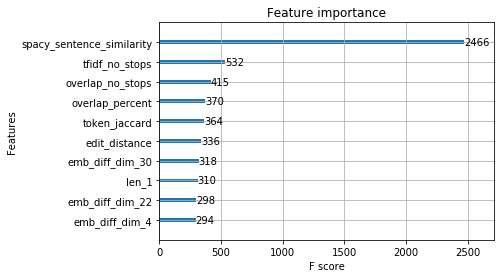

In [17]:
xgb.plot_importance(bst,height=0.2,max_num_features=10)

In [14]:
rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)
print("RFR fitted")

y_rfr_predicted = rfr.predict_proba(X_validate)
logloss_rfr = calculate_logloss(y_validate, y_rfr_predicted)


print ("The calculated log loss value on the test set using RFR is = %f" %logloss_rfr)

RFR fitted
The calculated log loss value on the test set using RFR is = 0.644447


In [18]:
#Oversample negative training sample 
pos_train = feature_train[feature_train["is_duplicate"] == 1]
neg_train = feature_train[feature_train["is_duplicate"] == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
print(scale)
while scale > 1:
    
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

feature_train = pd.concat([pos_train, neg_train])
X_train, y_train = xy_split(feature_train)
#y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

                                        

1.2373116507277628
0.1912475612920587


In [19]:
X_train, y_train = xy_split(feature_train)
X_validate, y_validate = xy_split(feature_validation)

[0]	train-logloss:0.605065	valid-logloss:0.640055
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.392595	valid-logloss:0.548113
[20]	train-logloss:0.372768	valid-logloss:0.543956
[30]	train-logloss:0.367435	valid-logloss:0.540556
[40]	train-logloss:0.363046	valid-logloss:0.536581
[50]	train-logloss:0.358429	valid-logloss:0.531969
[60]	train-logloss:0.355079	valid-logloss:0.529723
[70]	train-logloss:0.352118	valid-logloss:0.527663
[80]	train-logloss:0.348579	valid-logloss:0.525079
[90]	train-logloss:0.346374	valid-logloss:0.52388
[100]	train-logloss:0.343913	valid-logloss:0.522207
[110]	train-logloss:0.34131	valid-logloss:0.52086
[120]	train-logloss:0.339108	valid-logloss:0.520149
[130]	train-logloss:0.337077	valid-logloss:0.519232
[140]	train-logloss:0.335036	valid-logloss:0.518371
[150]	train-logloss:0.333006	valid-logloss:0.5177
[160]	train-logloss:0.330771	vali

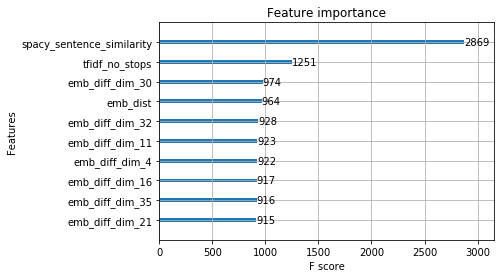

In [20]:
#XG BOOST
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
#params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_validate, label=y_validate)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=10)
xgb.plot_importance(bst,height=0.2,max_num_features=10)

In [ ]:
# Add single entity feature 
def upper_str(input_str):
    input_str = input_str.upper()
    return input_str

def upper_dataset(full_dataset):
    """
    Function that cleans the full dataset
    """
    full_dataset["clean_q1"] = full_dataset["clean_q1"].apply(upper_str,1)
    full_dataset["clean_q2"] = full_dataset["clean_q2"].apply(upper_str,1)
    return full_dataset

X_train=upper_dataset(X_train)
X_valid=upper_dataset(X_validate)
X_test=upper_dataset(X_test)

def singleentity(row):
    """
    Function that calculates where there is any entity difference between the two questions
    """
    doc_1 = nlp(row["clean_q1"])
    doc_2 = nlp(row["clean_q2"])
    if len(doc_1.ents)!=len(doc_2.ents):
        return 1
    else:
        for ent in doc_2.ents:
            if ent not in doc_1.ents:
                return 1
    return 0

X_train["singleentity"]=X_train.apply(singleentity,1)
X_valid["singleentity"]=X_valid.apply(singleentity,1)
X_test["singleentity"]=X_test.apply(singleentity,1)



In [ ]:
# Add edit distance feature
def distance(row):
    """
    Function that calculates the percentage of edit distance over the average length
    """
    token_1 = nltk.word_tokenize(row["clean_q1"])
    token_2 = nltk.word_tokenize(row["clean_q2"])
    avg_length = float(len(token_1)+len(token_2))/2
    return float(nltk.edit_distance(token_1,token_2))/avg_length

X_train["Edit_distance"]=X_train.apply(distance,1)
X_valid["Edit_distance"]=X_valid.apply(distance,1)
X_test["Edit_distance"]=X_test.apply(distance,1)


In [ ]:
# Add % of length of the longest common sequence
#### May not use as it takes a long time to run ####
def lcs(xstr, ystr):
    if not xstr or not ystr:
        return 0
    x, xs, y, ys = xstr[0], xstr[1:], ystr[0], ystr[1:]
    if x == y:
        return 1 + lcs(xs, ys)
    else:
        return max(lcs(xstr, ys), lcs(xs, ystr))

def longestcommonsequence(row):
    token_1 = nltk.word_tokenize(row["clean_q1"])
    token_2 = nltk.word_tokenize(row["clean_q2"])
    avg_length = float(len(token_1)+len(token_2))/2
    return lcs(token_1,token_2)/avg_length  

X_train["LCS"]=X_train.apply(longestcommonsequence,1)
X_valid["LCS"]=X_valid.apply(longestcommonsequence,1)
X_test["LCS"]=X_test.apply(longestcommonsequence,1)

In [ ]:
# Add similarity score 
def similarity(row):
    sent_1 = nlp(row["clean_q1"])
    sent_2 = nlp(row["clean_q2"])
    return sent_1.similarity(sent_2)  

X_train["Similarity"]=X_train.apply(similarity,1)
X_valid["Similarity"]=X_valid.apply(similarity,1)
X_test["Similarity"]=X_test.apply(similarity,1)

In [ ]:
#XG BOOST
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_validate, label=y_validate)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50)